# Flatiron School Phase 1 Project

This Jupyter Notebook contains analyses of various movie-related datasets. The point the of these analyses is to produce three recommendations for fictional stakeholders at Microsoft, who are looking to get into the movie business.

After conducting initial EDA on these datasets, I have produced my three recommendations. I will divide this notebook into three sections: one focusing on budget, another focusing on genre, and one focusing on the type of cast and crew.

### Importing packages & data

In [1]:
import pandas as pd
import numpy as np
import math
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) # So I don't have to call 'globals()' every time
import sqlite3
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid") # For aesthetic purposes

In [2]:
# Importing plain text-formatted data files
boxofficemojo = pd.read_csv("data/bom.movie_gross.csv")
thenumbers = pd.read_csv("data/tn.movie_budgets.csv")
rottentomatoes_movies = pd.read_csv("data/rt.movie_info.tsv", delimiter="\t")
rottentomatoes_reviews = pd.read_csv("data/rt.reviews.tsv", delimiter="\t")
themoviedatabase = pd.read_csv("data/tmdb.movies.csv")

conn = sqlite3.connect("data/im.db") # Connecting to the imdb SQLite database

# Retreiving each individual table from the imdb database
movie_basics = pd.read_sql(""" SELECT * FROM movie_basics """, conn)
directors = pd.read_sql(""" SELECT * FROM directors """, conn)
known_for = pd.read_sql(""" SELECT * FROM known_for """, conn)
movie_akas = pd.read_sql(""" SELECT * FROM movie_akas """, conn)
movie_ratings = pd.read_sql(""" SELECT * FROM movie_ratings """, conn)
persons = pd.read_sql(""" SELECT * FROM persons """, conn)
principals = pd.read_sql(""" SELECT * FROM principals """, conn)
writers = pd.read_sql(""" SELECT * FROM writers """, conn)

# Areas of Focus

Throughout this notebook, I will be focusing on three different areas of the movie industry. Each area will have its own section, where I will explain my methods and interpret my results. At the end of each section I will outline my recommendation.

 - **Cast & Crew**: *which professions to prioritize*
 - **Advertising**: *which areas to prioritize*
 - **Genre**: *which ones to avoid and which ones are safe bets*

# Measures of Success

It is important to define how I am measuring a movie's success going forward. I am using two statistics for this. These are *my own* metrics and, outside of common knowledge, I have not taken these ideas from anywhere else.

- ROI (return on investment, continuous variable)
    - Calculated as **the overall gross of a movie divided by its budget.**
    - A movie breaks even if its ROI is 100% – this means it made just as much as it put in.
    - A movie is profitable if ROI > 100%, and unprofitable if ROI < 100%.
    - If a movie's ROI is 450%, it made 4.5x as much as it spent.
    
    
- Profitable (boolean variable)
    - Equals True or 1 if ROI > 100%
    - Equals False or 0 if ROI <= 100%
    

These metrics can also be used to help evaluate a person's success in the movie industry.

- Average ROI
    - The average ROI of all the movies a person has participated in
    - If a person's average ROI is 258%, the movies they're in have made, on average, 2.58x more than they're spent.
- Hitrate
    - The average value of the Profitable boolean across all movies a person has participated in.
    - If a person's hitrate is 67%, then 67% of the movies they're in have been profitable.

# Advertising – Data Selection

Among our datasets, there is only one with good budget data: **thenumbers** and **boxofficemojo**, of which the first has far more data points. Ideally, we want as many data points as possible to analyze. So, for this section, we will be analyzing **thenumbers** dataset.

In [3]:
advertisingdf = thenumbers.copy()
advertisingdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [4]:
# Giving some columns simpler names
advertisingdf.rename(columns={'production_budget': 'budget', 'release_date': 'date'}, inplace=True)

In [5]:
advertisingdf.head(1)

,id,date,movie,budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


# Advertising – Data Prep & Cleaning

Looking at the data above, we see there are no null values, which is a good thing. For the data to be in a suitable format for analysis, several things still need to be done.

- The production budget, domestic gross, worldwide gross, and release date columns need to be re-formatted as integers.

- We need to create foreign gross, ROI, profitable, and ROI-tier columns.

- We need to remove outliers from out dataset to avoid making unwarranted conclusions.

### Converting data columns to integer types

In [6]:
def money_to_int(x):
    """
    This function turns a money-formatted string with commas
    into an integer.
    """
    x = x[1:] #Eliminating the dollar sign
    
    #Removing the commas
    split = x.split(",")
    joined = "".join(split)
    
    #Turns the resulting string into an integer
    integer = int(joined)
    return integer

# Using our function to re-format three columns
to_convert = ['budget', 'domestic_gross', 'worldwide_gross']

for x in to_convert:
    advertisingdf[x] = advertisingdf[x].map(lambda x: money_to_int(x))
    
# Re-formatting the date column
advertisingdf['date'] = advertisingdf['date'].map(lambda x: int(x[-4:]))

### Creating foreign gross, profitable, and ROI columns

In [7]:
ROI = advertisingdf['worldwide_gross'] / advertisingdf['budget']
ROI = round(ROI*100, 2)
advertisingdf['ROI'] = ROI

advertisingdf['foreign_gross'] = advertisingdf['worldwide_gross'] - advertisingdf['domestic_gross']
advertisingdf['profitable'] = advertisingdf['ROI'].map(lambda x: True if x>100 else False)

### Eliminating outliers in budget, ROI, and worldwide gross columns

In [8]:
def is_outlier(x, df):
    """
    This function takes a value and its associated
    group of values as its arguments. It determines whether
    or not the value is an outlier in its dataset; if it is,
    it returns a null value. If not, it returns the original value.
    """

    q1, q3 = df.quantile([.25, .75])
    iqr = q3-q1
    
    lower_limit = q1 - (iqr*1.5)
    upper_limit = q3 + (iqr*1.5)
    
    if any([(x<lower_limit), (x>upper_limit)]):
        return np.nan
    else:
        return x

In [9]:
# Number of rows pre-cleaning
print("The previous dataframe had {} rows.\n".format(advertisingdf.shape[0]))

# The columns we want to clean
to_clean = [
    'budget',
    'ROI',
    'worldwide_gross'
]

for i in to_clean:
    advertisingdf[i] = advertisingdf[i].map(lambda x: is_outlier(x, advertisingdf[i]))


# This shows us how many 'outliers' are in each column. 
for i in to_clean:
    print(advertisingdf[i].isnull().value_counts())
    
advertisingdf.dropna(inplace=True)

# If this command isn't executed, Seaborn will return an error on subsequent boxplots
advertisingdf = advertisingdf.reset_index(drop=True)


# Number of rows post-cleaning
print("\nThe current dataframe has {} rows.".format(advertisingdf.shape[0]))

The previous dataframe had 5782 rows.

False    5351
True      431
Name: budget, dtype: int64
False    5287
True      495
Name: ROI, dtype: int64
False    5178
True      604
Name: worldwide_gross, dtype: int64

The current dataframe has 4695 rows.


### Creating the ROI-tier column

This categorizes a movie based on its ROI.

In [10]:
# The number of bins we split ROI into
num_bins = 15

# Creating the endpoints for our ranges
ROI_range = np.linspace(0, 
                           1000,
                           num_bins, dtype=int)

# Creating neatly formatted strings for our ranges
ROIstrings = [str(round(i,1)) + ' percent' for i in ROI_range]
ROIranges = ["{} – {}".format(ROIstrings[i], ROIstrings[i+1]) for i in range(len(ROIstrings)-1)]

# Creating the budget category column for our dataframe
ROItier = pd.cut(advertisingdf['ROI'], bins=ROI_range, labels=ROIranges)
advertisingdf['ROItier'] = ROItier

In [11]:
# The number of bins we split budget into
num_bins = 10

# Creating the endpoints for our ranges
budget_range = np.linspace(0, 
                           advertisingdf['budget'].max(),
                           num_bins, dtype=int)

# Creating neatly formatted strings for our ranges
tierstrings = [str(round(i/1000000, 1)) + ' million' for i in budget_range]
tierranges = ["{} – {}".format(tierstrings[i], tierstrings[i+1]) for i in range(len(tierstrings)-1)]

# Creating the budget category column for our dataframe
money_range = pd.cut(advertisingdf['budget'], bins=budget_range, labels=tierranges)
advertisingdf['budget_category'] = money_range.astype(object)

### Re-ordering columns

In [12]:
advertisingdf = advertisingdf[['id', 'date', 'movie', 'budget', 'budget_category',
                               'domestic_gross', 'foreign_gross',
                               'worldwide_gross', 'ROI', 'ROItier',
                               'profitable']]
advertisingdf.head(1)

,id,date,movie,budget,budget_category,domestic_gross,foreign_gross,worldwide_gross,ROI,ROItier,profitable
0,32,2008,The Spiderwick Chronicles,92500000.0,82.2 million – 92.5 million,71195053,91644614,162839667.0,176.04,142 percent – 214 percent,True


# Advertising – Question and Analysis

Our question for this section is: which areas of advertising should be prioritized? There are two such areas to compare – domestic advertising and foreign advertising.

There are several things we need to do in order to answer this question competently.

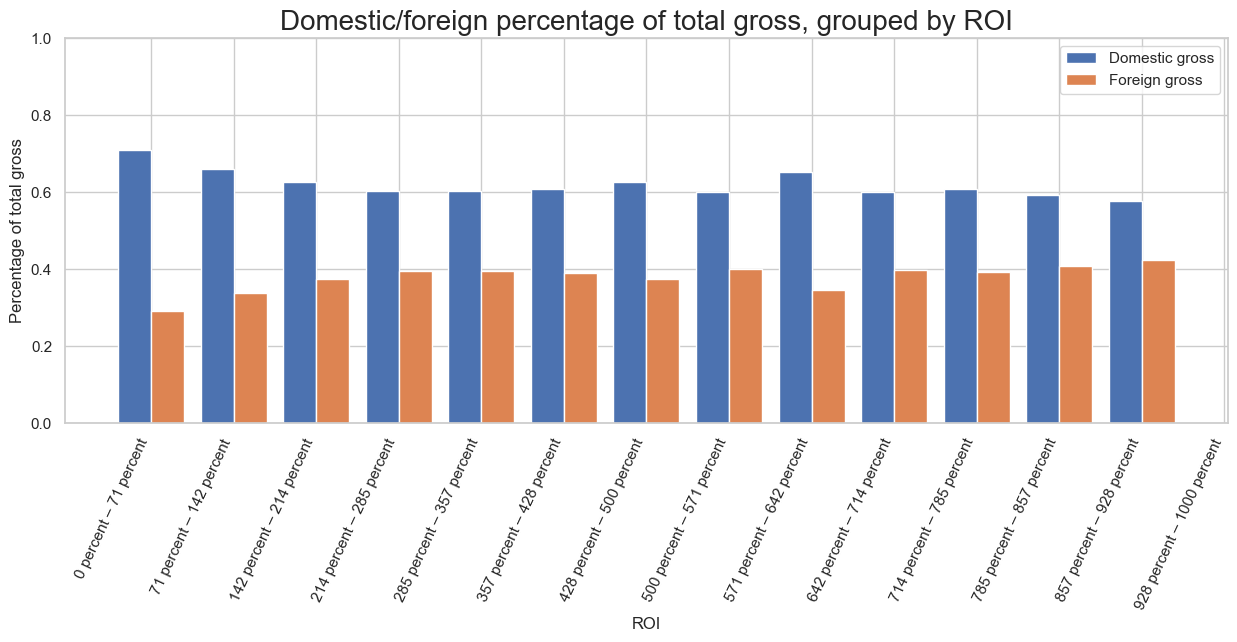

In [13]:
fig, ax = plt.subplots(figsize=(15,5))

x = ROIranges # the clearly formatted string for all ROI tiers
domestic_percentage_means = [] # domestic gross percentage of total gross per ROI tier
foreign_percentage_means = [] # foreign gross percentage of total gross per ROI tier

for i in ROIranges:
    df = advertisingdf[advertisingdf.ROItier == i]
    
    try:
        domestic_percentage = df['domestic_gross'] / df['worldwide_gross']
        foreign_percentage = df['foreign_gross'] / df['worldwide_gross']

        domestic_percentage_means.append(domestic_percentage.mean())
        foreign_percentage_means.append(foreign_percentage.mean())
    except:
        continue
    
x_axis = np.arange(len(x))
barplot1 = ax.bar(x_axis-0.2, domestic_percentage_means,0.4, label='Domestic gross')
barplot2 = ax.bar(x_axis+0.2, foreign_percentage_means,0.4, label='Foreign gross')

ax.set_xticks(x_axis, x, rotation=65, horizontalalignment='right')
ax.set_xlabel("ROI")
ax.set_ylabel("Percentage of total gross")

ax.set_ylim(0,1)

ax.legend(loc='upper right')
ax.set_title("Domestic/foreign percentage of total gross, grouped by ROI", fontsize=20);

In [14]:
# Two datasets for use in the visualizations below
unprofitable = advertisingdf[advertisingdf.profitable==False] # All unprofitable movies
profitable = advertisingdf[advertisingdf.profitable==True] # All profitable movies

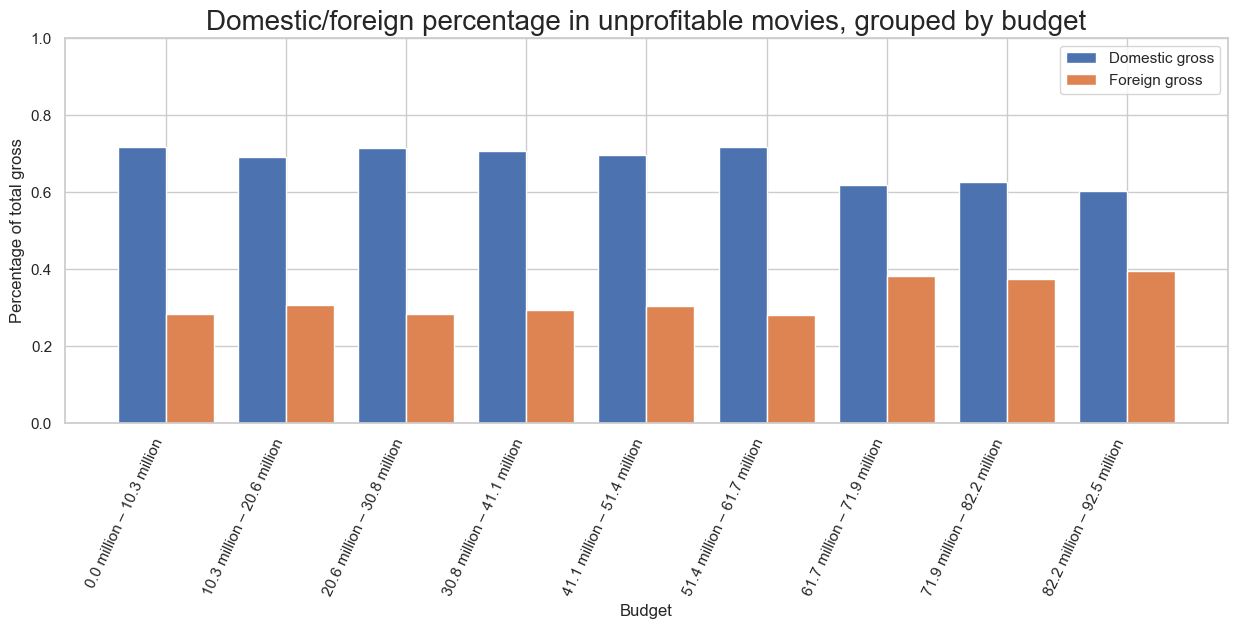

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

x = tierranges # the clearly formatted string for all ROI tiers
domestic_percentage_means = [] # domestic gross percentage of total gross per ROI tier 
foreign_percentage_means = [] # foreign gross percentage of total gross per ROI tier

for i in x:
    df = unprofitable[unprofitable.budget_category == i]
    
    try:
        domestic_percentage = df['domestic_gross'] / df['worldwide_gross']
        foreign_percentage = df['foreign_gross'] / df['worldwide_gross']

        domestic_percentage_means.append(domestic_percentage.mean())
        foreign_percentage_means.append(foreign_percentage.mean())
    except:
        continue
    
x_axis = np.arange(len(x))
barplot1 = ax.bar(x_axis-0.2, domestic_percentage_means,0.4, label='Domestic gross')
barplot2 = ax.bar(x_axis+0.2, foreign_percentage_means,0.4, label='Foreign gross')

ax.set_xticks(x_axis, x, rotation=65, horizontalalignment='right')
ax.set_xlabel("Budget")
ax.set_ylabel("Percentage of total gross")

ax.set_ylim(0,1)

ax.legend(loc='upper right')
ax.set_title("Domestic/foreign percentage in unprofitable movies, grouped by budget", fontsize=20);

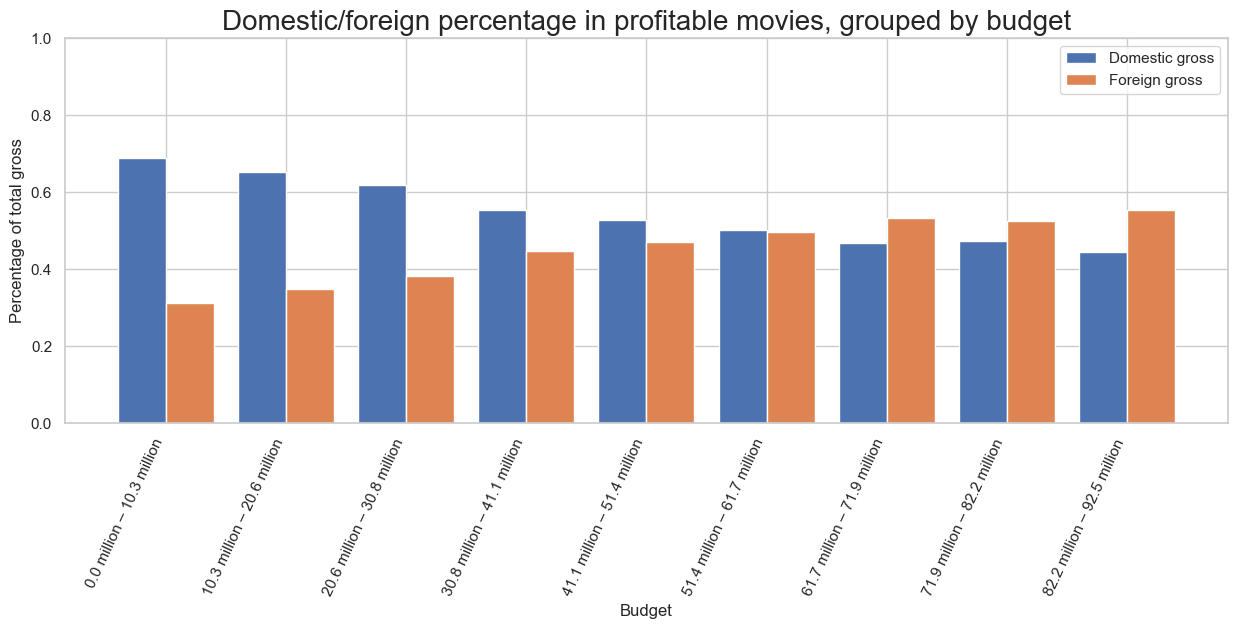

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

x = tierranges # the clearly formatted string for all ROI tiers
domestic_percentage_means = [] # domestic gross percentage of total gross per ROI tier 
foreign_percentage_means = [] # foreign gross percentage of total gross per ROI tier

for i in x:
    df = profitable[profitable.budget_category == i]
    
    try:
        domestic_percentage = df['domestic_gross'] / df['worldwide_gross']
        foreign_percentage = df['foreign_gross'] / df['worldwide_gross']

        domestic_percentage_means.append(domestic_percentage.mean())
        foreign_percentage_means.append(foreign_percentage.mean())
    except:
        continue
    
x_axis = np.arange(len(x))
barplot1 = ax.bar(x_axis-0.2, domestic_percentage_means,0.4, label='Domestic gross')
barplot2 = ax.bar(x_axis+0.2, foreign_percentage_means,0.4, label='Foreign gross')

ax.set_xticks(x_axis, x, rotation=65, horizontalalignment='right')
ax.set_xlabel("Budget")
ax.set_ylabel("Percentage of total gross")

ax.set_ylim(0,1)

ax.legend(loc='upper right')
ax.set_title("Domestic/foreign percentage in profitable movies, grouped by budget", fontsize=20);

# Advertising – Recommendation

- Heavier emphasis on domestic rather than foreign advertising; it's a common theme among films of all different levels of success
- At the same time do not neglect foreign advertising; more successful films place a slightly heavier emphasis on foreign advertising, as do films with higher budgets.

# Genre – Data Collecting & Cleaning

Our biggest and best set of genre data comes from the im.db dataset. However, this dataset does not contain budget or gross information; if we want to measure the effects of genre on ROI or profitability, we will have to join several tables.

In [17]:
q = """
SELECT movie_basics.movie_id,
       advertisingdf.date,
       movie_basics.genres,
       advertisingdf.movie,
       advertisingdf.budget,
       advertisingdf.ROI,
       advertisingdf.profitable

FROM advertisingdf
JOIN movie_basics
    ON movie = primary_title
"""

genredf = pysqldf(q)
genredf.head(1)

,movie_id,date,genres,movie,budget,ROI,profitable
0,tt0359950,2013,"Adventure,Comedy,Drama",The Secret Life of Walter Mitty,91000000.0,206.44,1


### Eliminating Duplicates

In [18]:
genredf.movie_id.value_counts().value_counts() # There are many duplicate entries

1    2902
2      84
Name: movie_id, dtype: int64

In [19]:
genredf.movie_id.value_counts().head(2)

tt1321509    2
tt4463894    2
Name: movie_id, dtype: int64

In [20]:
genredf[genredf.movie_id == 'tt3555036']

,movie_id,date,genres,movie,budget,ROI,profitable
1005,tt3555036,1986,"Action,Drama",Legend,25000000.0,94.02,0
1042,tt3555036,2015,"Action,Drama",Legend,25000000.0,169.70,1


In [21]:
genredf[genredf.movie_id == 'tt2467046']

,movie_id,date,genres,movie,budget,ROI,profitable
1286,tt2467046,2001,"Action,Drama,Fantasy",Left Behind,18500000.0,22.82,0
1405,tt2467046,2014,"Action,Drama,Fantasy",Left Behind,16000000.0,129.81,1


It looks like the 'duplicate' entries contain conflicting data. It's clear we have to remove them.

In [22]:
q = """
SELECT * FROM genredf
WHERE movie_id NOT IN (SELECT movie_id
                       FROM genredf
                       GROUP BY movie_id
                       HAVING COUNT(*)>=2)
"""

genredf = pysqldf(q)

In [23]:
genredf.movie_id.value_counts().value_counts() # The duplicate entries are now gone

1    2902
Name: movie_id, dtype: int64

# Genre – Correlation with profitability

The most obvious question to ask is: which genres correlate most highly with ROI? To answer, we need to extract a list of all the genres available in our dataset. Once we do, we need to create a boolean column for each genre whose value is 1 if a movie is in that genre and 0 if not.

Those columns will be used to create a boolean table that is used to create a correlation matrix, which will be used to create a heatmap with the seaborn package. This heatmap will provide an easy visual method of identifying strong/weak correlations.

You might ask why we are selecting our boolean 'profitable' variable to correlate with genre choice. The other measure of success we have, ROI, is a continuous variable, and I am not sure of how to correlate a boolean variable (genre) with a continuous variable (ROI).

In [24]:
# Extracting list of unique genres

genres = (list(genredf['genres'].unique()))
genres.remove(None) # Removing Nonetypes from the list
genres = ",".join(genres)
genres = genres.split(",")
genres = sorted(list(set(genres)))

genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [25]:
# Eliminating null values from genres column
genredf['genres'] = genredf['genres'].map(lambda x: 'None' if not x else x)

### Creating boolean dataframe for genres

In [26]:
genrebooldf = pd.DataFrame()

# Populating boolean dataframe
for i in genres:
    genrebooldf["is_"+i] = genredf['genres'].map(lambda x: True if i in x else False)
    
# Adding profitable column to boolean dataframe
genrebooldf['profitable'] = genredf['profitable']

# Adding ROI column to boolean dataframe
genrebooldf['ROI'] = genredf['ROI']

In [27]:
genrebooldf

,is_Action,is_Adventure,is_Animation,is_Biography,is_Comedy,is_Crime,is_Documentary,is_Drama,is_Family,is_Fantasy,...,is_News,is_Reality-TV,is_Romance,is_Sci-Fi,is_Sport,is_Thriller,is_War,is_Western,profitable,ROI
0,False,True,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1,206.44
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,1,184.33
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,1,184.33
3,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,1,180.58
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1,180.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,0,0.00
2898,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,5.27
2899,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,0,50.93
2900,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,0,0.00


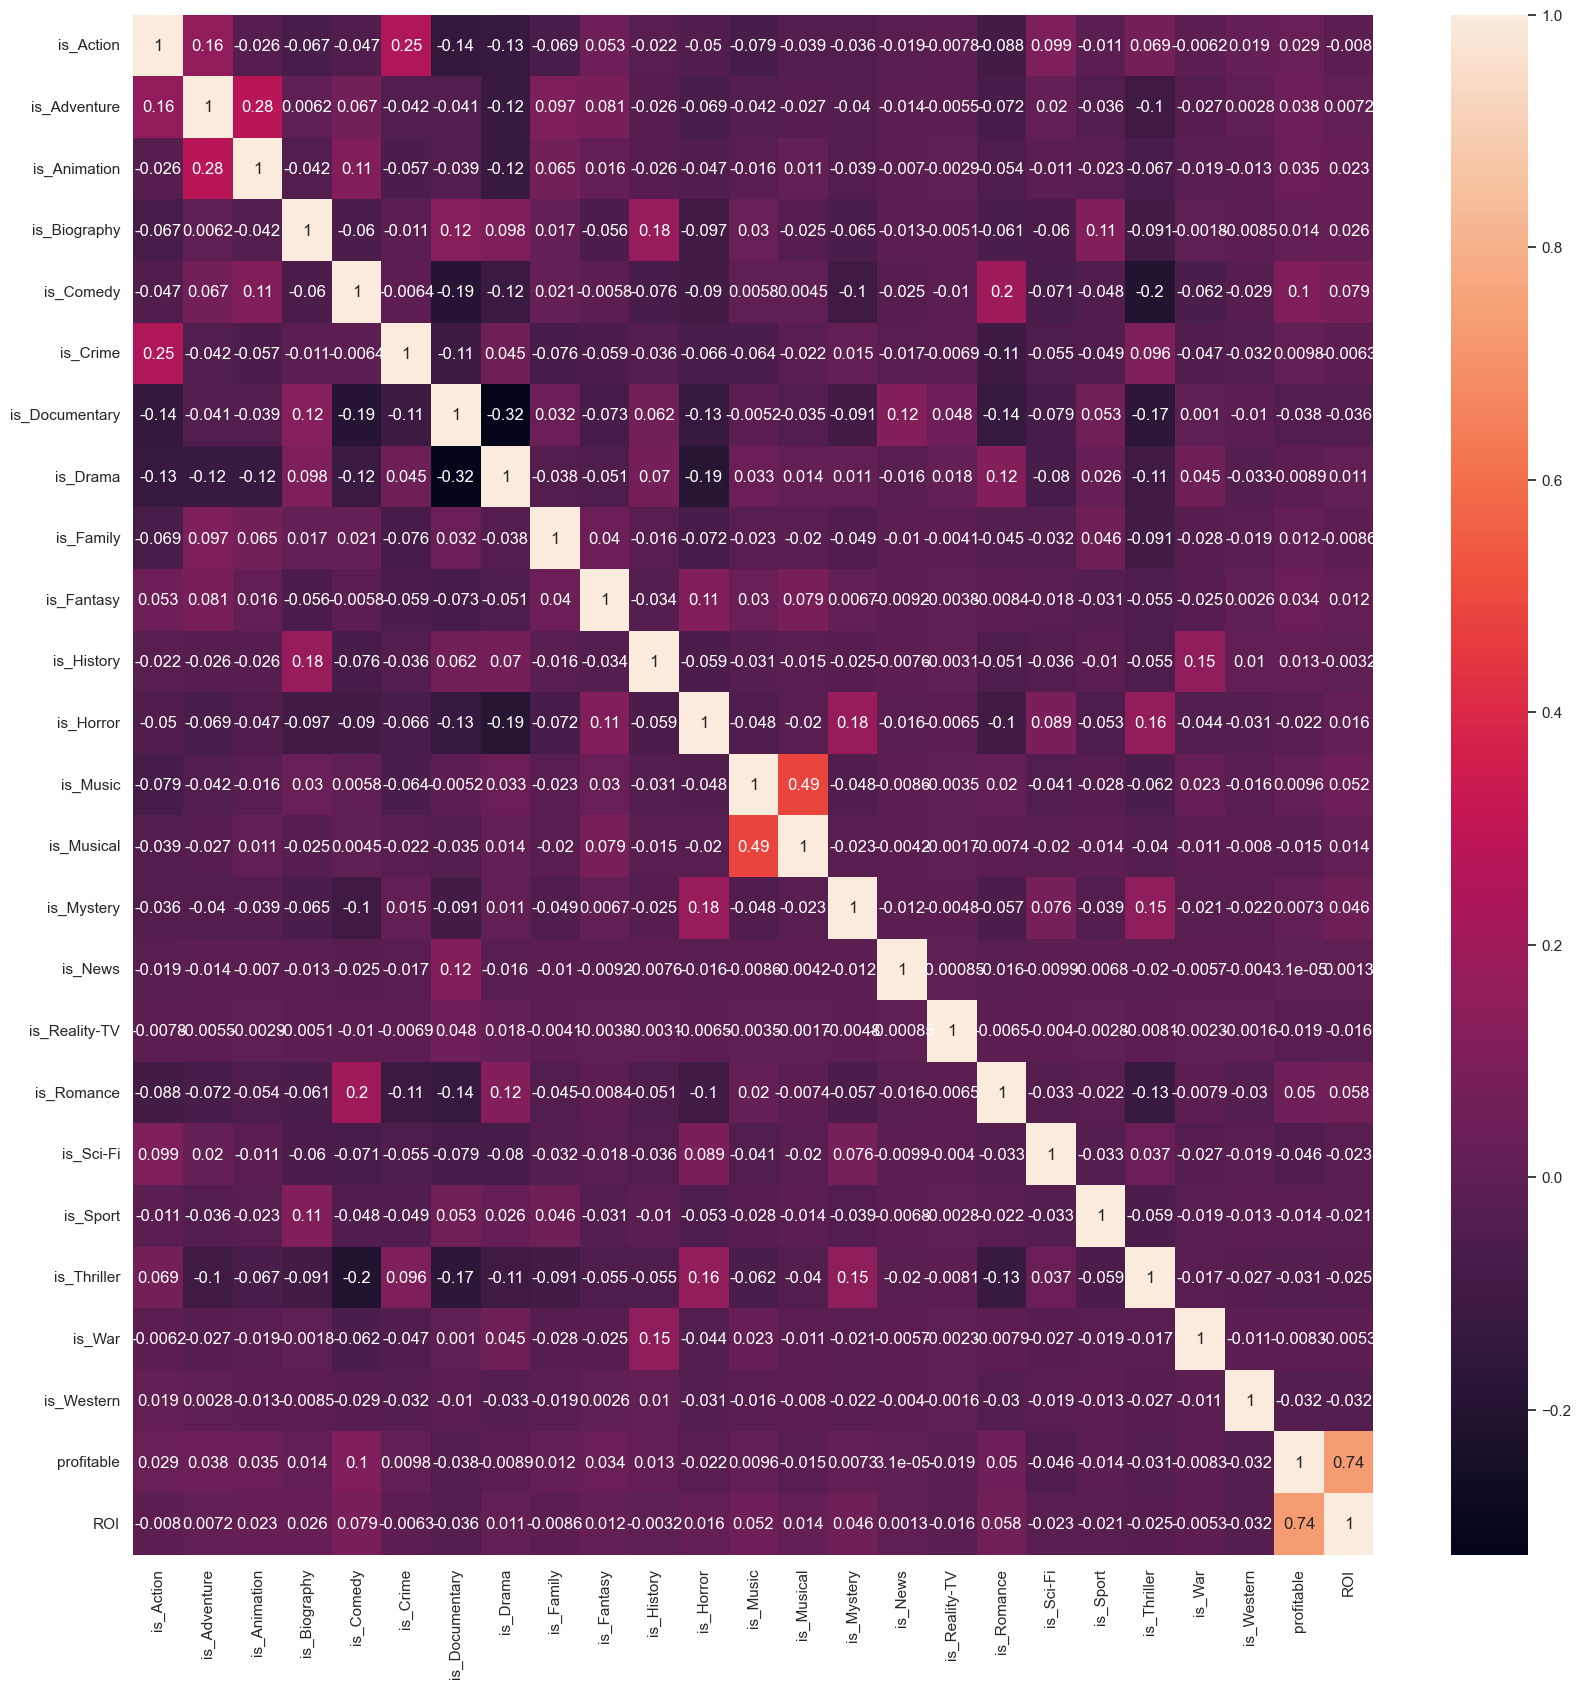

In [28]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(genrebooldf.corr(), ax=ax, annot=True);

In [29]:
genrebooldf.corr().sort_values('profitable', ascending=False)['profitable']

profitable        1.000000
ROI               0.735762
is_Comedy         0.100350
is_Romance        0.050090
is_Adventure      0.037882
is_Animation      0.034523
is_Fantasy        0.033701
is_Action         0.029168
is_Biography      0.013669
is_History        0.012899
is_Family         0.011686
is_Crime          0.009767
is_Music          0.009621
is_Mystery        0.007338
is_News           0.000031
is_War           -0.008280
is_Drama         -0.008949
is_Sport         -0.013975
is_Musical       -0.015157
is_Reality-TV    -0.018554
is_Horror        -0.021760
is_Thriller      -0.030644
is_Western       -0.031722
is_Documentary   -0.037570
is_Sci-Fi        -0.046494
Name: profitable, dtype: float64

### Conclusion

The correlations we have from this analysis are so weak that they can't inform any recommendations.

# Genre - Correlation with profitability (2nd approach)

We should approach this differently. What if we measured the hitrate (rate of profitability) of movies three times for each genre: once when the genre is present, once when it is absent, and once across both states (average hitrate), and compared all three hitrates?

For this visualization, I am also going to calculate error bars with the standard error (standard deviation of sample divided by sample size).

In [30]:
# This list will contain:
# average hitrate, hitrate with the genre, hitrate without the genre,
# and the std/sample sizes necessary to calculate the standard errors for all three of those.
genre_rois=[]

In [31]:
# Average ROI here
average = genrebooldf['ROI'].mean()

for i in range(len(genres)):
    
    genre = genres[i]
    colname = "is_" + genre
    
    # ROI with genre
    on = genrebooldf[(genrebooldf[colname]==1)]['ROI'].mean()
    
    std = (np.std(genrebooldf[(genrebooldf[colname]==1)])['ROI'])
    
    sample_size = len(genrebooldf[(genrebooldf[colname]==1)])
    
    root = math.sqrt(sample_size)
    
    # Appending to main list
    genre_rois.append([on, std, root])

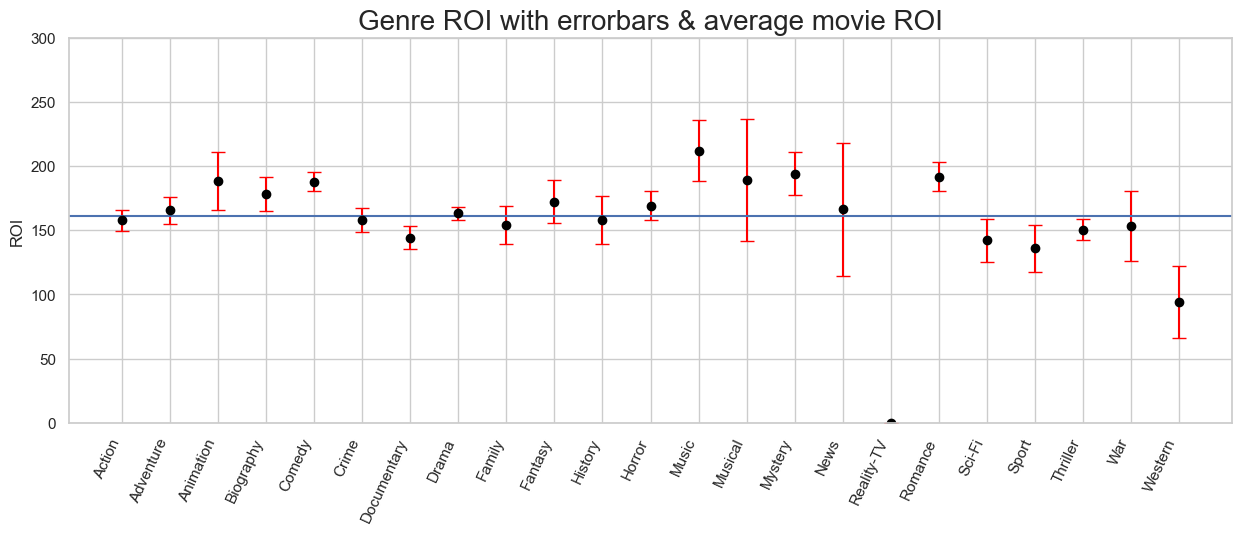

In [32]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Genre ROI with errorbars & average movie ROI", fontsize=20)
    
x = genres
y = [i[0] for i in genre_rois]

errorbars = []

for i in range(len(genre_rois)):
    std = genre_rois[i][1]
    root = genre_rois[i][2]
    errorbar = std/root
    errorbars.append(errorbar)


plt.errorbar(x,y, yerr=errorbars, fmt='o', color='black', ecolor='red', capsize=5)
ax.set_ylim(0, 300)

plt.xticks(rotation=65, horizontalalignment='right')

plt.ylabel('ROI')

ax.axhline(average, xmin=0, xmax=250);

In [33]:
# This list will contain:
# average hitrate, hitrate with the genre, hitrate without the genre,
# and the std/sample sizes necessary to calculate the standard errors for all three of those.
genre_hitrates=[]

In [34]:
# Average hitrate here
average = len(genrebooldf[genrebooldf.profitable == 1])/len(genrebooldf)

for i in range(len(genres)):
    
    genre = genres[i]
    colname = "is_" + genre
    
    # Hitrate with genre
    on = len(genrebooldf[(genrebooldf[colname]==1) & (genrebooldf.profitable==1)])/\
         len(genrebooldf[(genrebooldf[colname]==1)])
    
    std = (np.std(genrebooldf[(genrebooldf[colname]==1)])['profitable'])
    
    sample_size = len(genrebooldf[(genrebooldf[colname]==1)])
    
    root = math.sqrt(sample_size)
    
    # Appending to main list
    genre_hitrates.append([on, std, root])

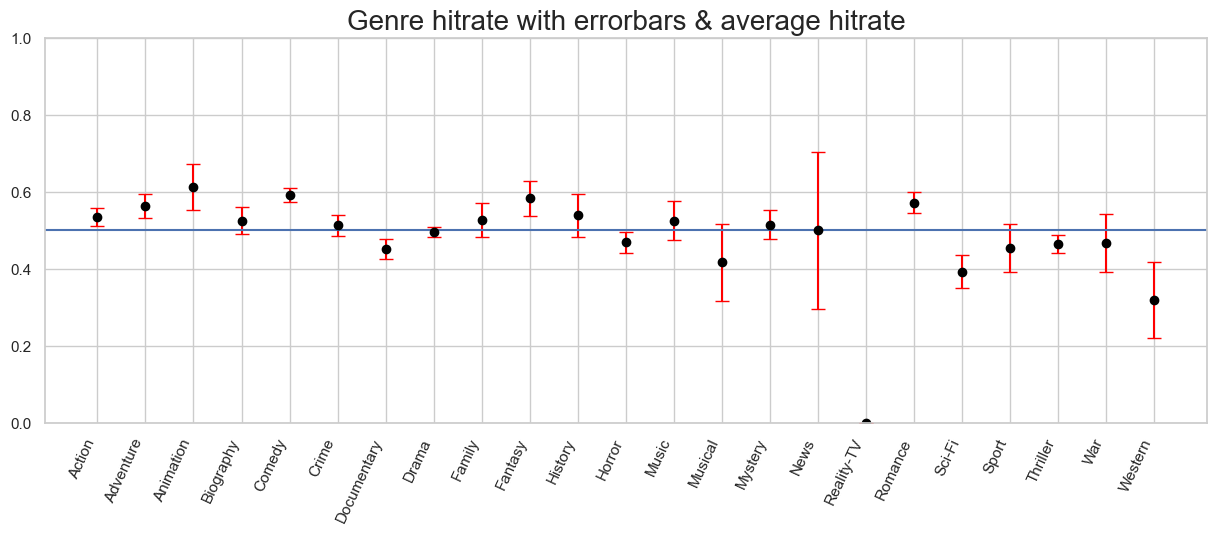

In [35]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Genre hitrate with errorbars & average hitrate", fontsize=20)
    
x = genres
y = [i[0] for i in genre_hitrates]

errorbars = []

for i in range(len(genre_hitrates)):
    std = genre_hitrates[i][1]
    root = genre_hitrates[i][2]
    errorbar = std/root
    errorbars.append(errorbar)


plt.errorbar(x,y, yerr=errorbars, fmt='o', color='black', ecolor='red', capsize=5)
ax.set_ylim(0, 1)

plt.xticks(rotation=65, horizontalalignment='right')

ax.axhline(average, xmin=0, xmax=250);

# Genre – Recommendation

- Avoid (do not use if possible):
    - Documentary
    - Reality TV
    - Sci-Fi
    - Sport
    - Thriller
    - Western
    - News

- Safe bets (use these if possible):
    - Comedy
    - Fantasy
    - Romance
    
- Average (the recommendation does not say to avoid or use these):
    - Action
    - Adventure
    - Biography
    - Crime
    - Drama
    - Family
    - History
    - Horror
    - Music
    - Musical
    - Mystery
    - War

# Cast – Data Collection & Cleaning

Look at the principals dataset below. It lists the entire cast for each movie, with details on their job in the movie and characters they play (if applicable). The dataset for this section should have similar data, with some added/re-arranged columns:


- person_id (from principals)
- primary_name (from persons)
- profession (from principals)
- movie_id (from our dataset in the last section)
- year (from our dataset in the last section)
- ROI (from our dataset in the last section)
- profitable (from our dataset in the last section)



We can eliminate the following columns, as they are no longer needed for analysis:

- runtime
- budget
- budget category
- all gross columns

In [36]:
principals.head(1)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"


In [37]:
q = """
SELECT person_id,
       primary_name AS name,
       category AS profession,
       movie_id,
       date AS year,
       ROI,
       profitable AS hitrate

FROM genredf
JOIN principals
    USING(movie_id)
JOIN persons
    USING(person_id)
"""

castdf = pysqldf(q)

In [38]:
castdf.head(1)

,person_id,name,profession,movie_id,year,ROI,hitrate
0,nm0001774,Ben Stiller,actor,tt0359950,2013,206.44,1


# Cast – Choice of Profession

For the questions in this section, we will focus on the following professions:


- Actors
- Actresses
- Directors
- Producers
- Writers


As you can see from the list below, we are choosing to ignore the following professions:


- Composers
- Editors
- 'Self' (?)
- Cinematographers
- Production designers
- Archive_footage

In [39]:
professions = list(castdf['profession'].unique())
professions

['actor',
 'writer',
 'producer',
 'composer',
 'actress',
 'director',
 'editor',
 'self',
 'cinematographer',
 'production_designer',
 'archive_footage']

In [40]:
# Updating professions list
professions = ['actor', 'actress', 'director', 'producer', 'writer']

# Cast – Predictive Questions

In this section, we will find out the impact each profession has on a movie's success. We can approach this in four different ways:

- Impact of profession's ROI on movie's ROI
- Impact of profession's ROI on movie's hitrate
- Impact of profession's hitrate on movie's ROI
- Impact of profession's hitrate on movie's hitrate


Each of these questions is a predictive question, and cannot be done with a single dataset. In order to answer any of these, we will have to **split** our dataset into two parts, along a particular year. We will then find out how well a variable in the first dataset correlates with a variable in the second dataset. This can give us at least some idea of any underlying causal relationships.

The idea is: if you were to select people in a profession based on one of their attributes, and make a movie with these people, what are the chances of your movie succeeding? Splitting our dataset down a year and comparing values is as close as we can come to answering this question.

In [41]:
years = sorted(castdf.year.unique())
len(years)

61

That's a lot of years!

When you split down a year, you want to make sure of two things:

- You maximized the number of people in common between the two datasets (even if you have 5000 people in one and 5000 in the second, what good does that do if none of the people from the first are in the second?)
- The characteristics of the people in common do not differ wildly between the two datasets.

In [42]:
attributes = ('ROI', 'hitrate')

for year in years:
    
    differences = []
    
    before = castdf[castdf.year <= year].copy() # All data before or during that year
    after = castdf[castdf.year > year].copy() # All data after that year


    # Getting the list of people in common
    intersection = set(before.person_id.unique()).intersection(set(after.person_id.unique()))
    len(intersection)


    # Reducing each dataset to only include people from the intersection
    before = before[before.person_id.isin(intersection)]
    after = after[after.person_id.isin(intersection)]
    
    for a in attributes:
        for i in professions:
            mean1 = before[before.profession==i][a].mean()
            mean2 = after[after.profession==i][a].mean()
            difference = abs(mean1 - mean2)
            average = np.mean([mean1, mean2], dtype=float)
            percentage = (difference/average)*100
            
            differences.append(percentage)
    
    average_difference = np.mean(differences)
    
    print(
        str(year) + " – intersection: ",
        len(intersection), # Number of unique people in common between datasets
        " ||  ",
        "average percentage difference: ",
        average_difference
    )

1927 – intersection:  1  ||   average percentage difference:  nan
1931 – intersection:  2  ||   average percentage difference:  nan
1940 – intersection:  2  ||   average percentage difference:  nan
1944 – intersection:  5  ||   average percentage difference:  nan
1945 – intersection:  7  ||   average percentage difference:  nan
1948 – intersection:  8  ||   average percentage difference:  nan
1950 – intersection:  12  ||   average percentage difference:  nan
1951 – intersection:  20  ||   average percentage difference:  nan
1956 – intersection:  25  ||   average percentage difference:  nan
1959 – intersection:  32  ||   average percentage difference:  83.96787669408687
1960 – intersection:  35  ||   average percentage difference:  72.0065787555531
1961 – intersection:  39  ||   average percentage difference:  51.0604688209428
1964 – intersection:  39  ||   average percentage difference:  51.0604688209428
1965 – intersection:  41  ||   average percentage difference:  51.256383053914405


It looks like splitting down the year 2012 would be a good balance between maximizing people and minimizing percentage difference. However, any of the years between 2011 and 2015 would be good candidates, as they offer a lot of people and an average percentage difference under 10%.

In [43]:
year = 2013
before = castdf[castdf.year <= year].copy() # All data before or during 2013
after = castdf[castdf.year > year].copy() # All data after 2013


# Getting the list of people in common
intersection = set(before.person_id.unique()).intersection(set(after.person_id.unique()))
len(intersection)


# Reducing each dataset to only include people from the intersection
before = before[before.person_id.isin(intersection)]
after = after[after.person_id.isin(intersection)]

# Cast – Impact of profession's ROI on movie's ROI

We started off this section with a lot of questions, but we should only tackle one to begin with. Our strategy is as follows:

- Divide ROI into bins (e.g., between 200-300%, 400-500%, etc.)
- Find the people from the first dataset in each profession that fall into these bins
- Locate the same people in the second dataset and measure the success of the movies they're in
- Plot each ROI bin against movie success from the second dataset
- Measure the correlation and predictive power for each profession

In [44]:
def query(profession, profession_attribute, movie_attribute):
    
    """
    This function takes three arguments: a profession, one attribute of the profession,
    and one attribute of the movies that involve people from that profession.
    
    Example: query('actor', 'ROI', 'hitrate')
    
    The function will query a subset from the first dataset that contains only actors, and categorize
    the ROI column in that subset into multiple bins. For each of those bins, it will locate the people
    that fall into those bins. The function then locates all movies in the second dataset with those people
    and evaluates the hitrate of those movies.
    
    The function will return:
    
    1) The profession it examined ('actor')
    2) The attributes it examined ('ROI' and 'hitrate')
    3) The bins that it divided ROI into
    4) The corresponding mean for each bin
    5) The correlation between actor ROI and movie hitrate
    6) The rsquared value of this correlation (just the correlation squared)
    """
    
    means = [] # Average movie attribute per bin
    bins = [] # Bins denoted in string form
    
    # Creating local references to datasets for use within function
    beforelocal = before
    afterlocal = after
    
    # Creating bins based on whether selected attribute is ROI or profitable
    # ROI will have much higher values, profitable will only have values between 0 and 1
    if profession_attribute == "ROI":
        linspace = np.linspace(0,1000,20, dtype=int)
    elif profession_attribute == "hitrate":
        linspace = np.linspace(0,1.01,20)
    else:
        return "Invalid profession attribute"
    
    for i in range(len(linspace)-1):

        # Gets all people from first dataset with ROI within a range
        q = """
        SELECT person_id
        FROM beforelocal
        GROUP BY person_id
        HAVING profession == '{}' AND AVG({})>{} AND AVG({})<{}
        """.format(profession, profession_attribute, linspace[i], profession_attribute, linspace[i+1])

        df1 = sqldf(q, locals())
        
        # Only gathering bins of a certain size to prevent misleading data
        if len(df1) < 5:
            continue

        # Retreiving data from the same people in the second dataset
        q2 = """
        SELECT *
        FROM afterlocal
        WHERE person_id IN (SELECT person_id FROM df1)
        """

        df2 = sqldf(q2, locals())

        # Appending the average ROI to our list
        means.append(df2[movie_attribute].mean())

        # Creating the strings for each bin
        start = linspace[i]
        end = linspace[i+1]
        bins.append('{} – {}, [{} values]'.format(round(start, 2), round(end, 2), len(df1)))
        
    
    # Correlation
    # This is calculated on the list of means we gathered from the movies in the second dataset.
    # If there are fewer than five means in this list, the correlation will not be meaningful.
    # The function will return a NaN value unless we have five or more data points.
    if len(means)>= 5:
        correlation = np.corrcoef(range(0,len(means)),means)[0,1]
    else:
        correlation = np.nan

    # R Squared values (predictive power)
    rsquared = correlation**2
    
    return (profession,
           profession_attribute,
           movie_attribute,
           bins,
           means,
           correlation,
           rsquared)

In [45]:
def plot(data):
    
    """
    This function creates a plot based on the results of the query function we created
    in this project. The title, x- and y- data, and annotations are all based on what the 
    query function returns.
    
    title: 0th, 1st, and 2nd items of query return
    x data: 3rd item
    y data: 4th item
    r annotation: 5th item
    r squared annotation: 6th item
    """
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    title = "{} {} as predictor of movie {}".format(data[0], data[1], data[2])
    ax.set_title(title, fontsize='20')
    
    x = data[3]
    y = data[4]
    
    # Sets limits of graph depending on the range of values available
    if max(y)>1:
        ax.set_ylim(0, 500)
    else:
        ax.set_ylim(0,1)


    plt.xticks(
        rotation=65,
        horizontalalignment = 'right'
    )

    # Code comes from https://www.python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib
    b, a = np.polyfit(range(0,len(y)), y, deg=1)
    xseq = np.linspace(0, len(y), num=100)
    ax.plot(xseq, a + b * xseq, color="k", lw=2.5);

    ax.text(.01,
             .99, 
             "r = {}".format(str(data[5])),
             ha='left',
             va='top',
             transform=ax.transAxes,
             fontsize = 15)
    
    ax.text(.01,
             .9, 
             "r² = {}".format(str(data[6])),
             ha='left',
             va='top',
             transform=ax.transAxes,
             fontsize = 15)
    
    ax.scatter(x, y);

# Cast – Putting it all together

We have defined two functions, a data query function and a plot function. We will now iterate through the list of professions we chose and plot average ROI vs movie ROI.

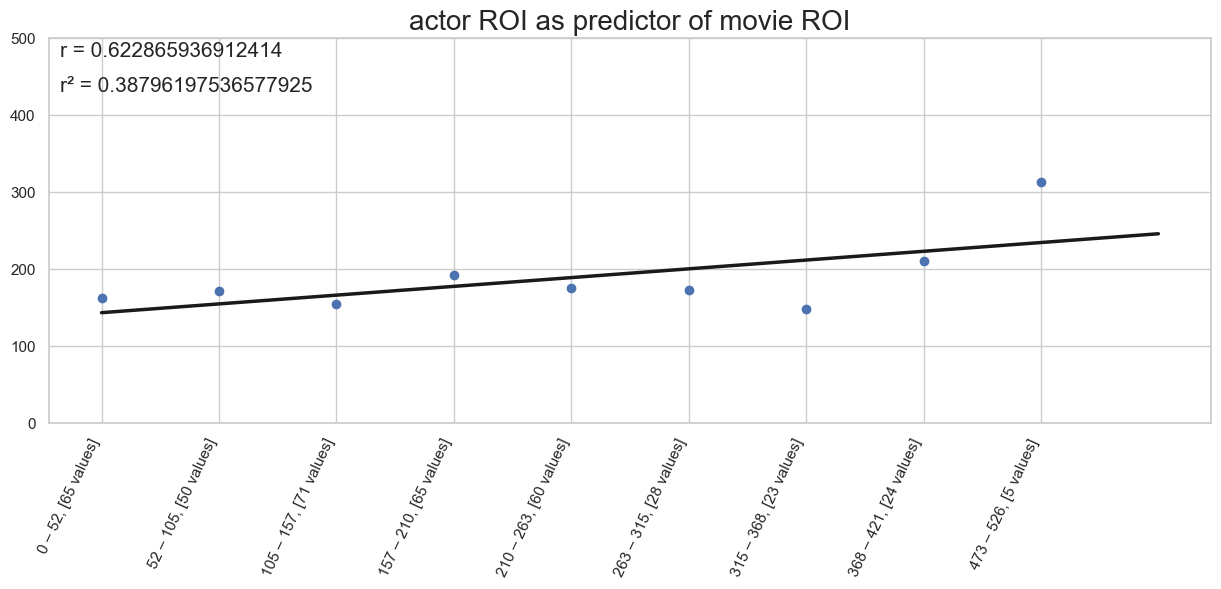

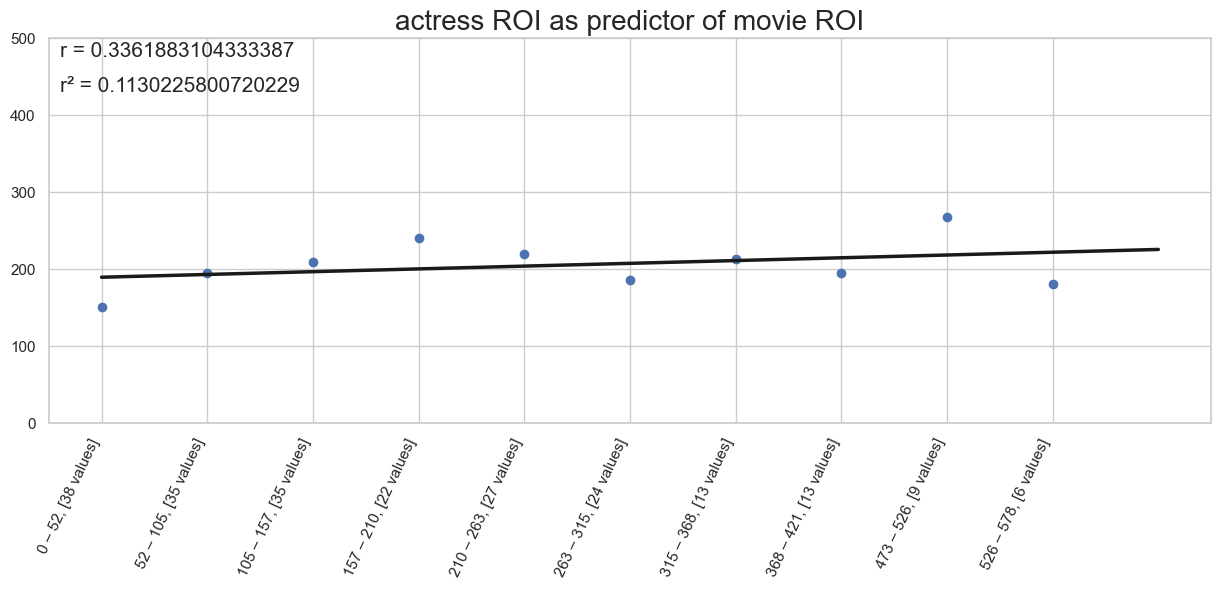

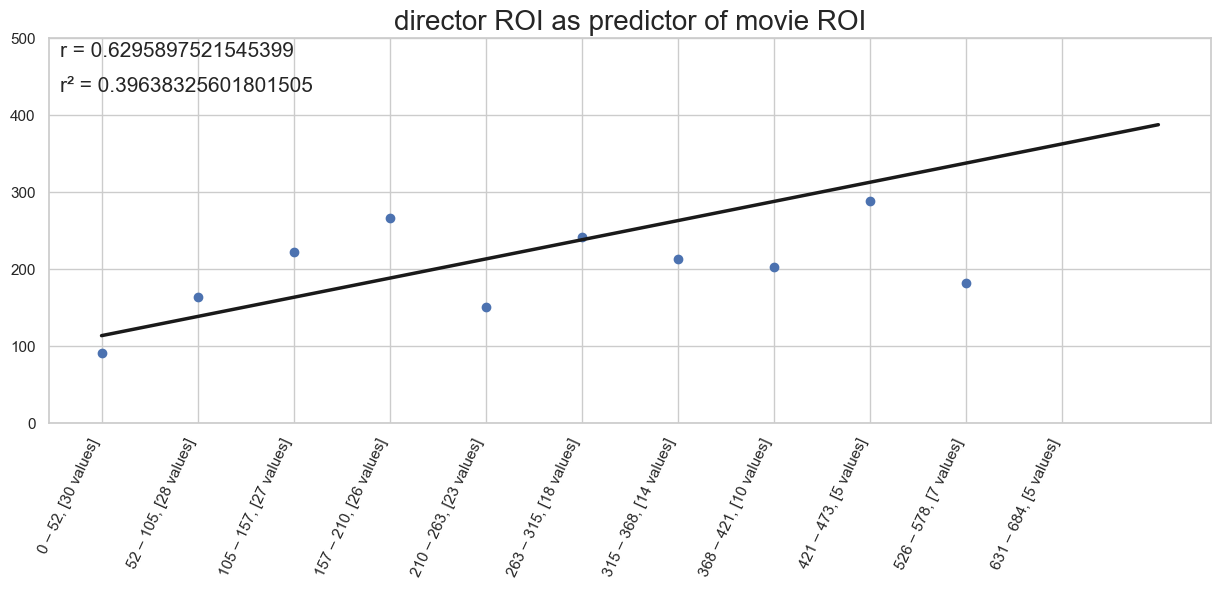

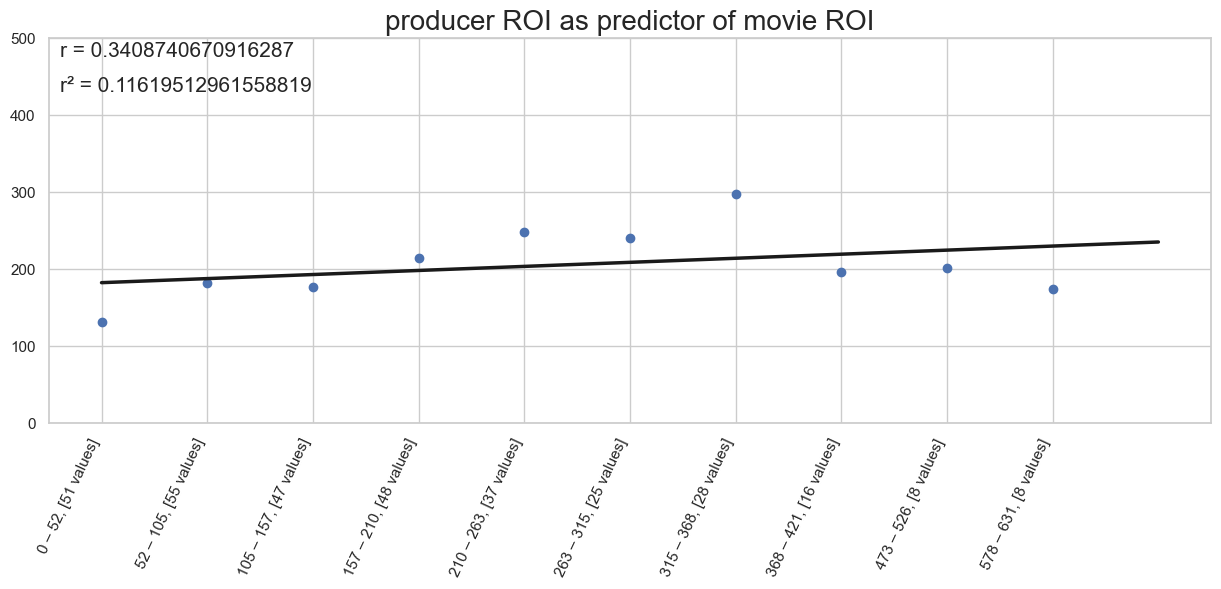

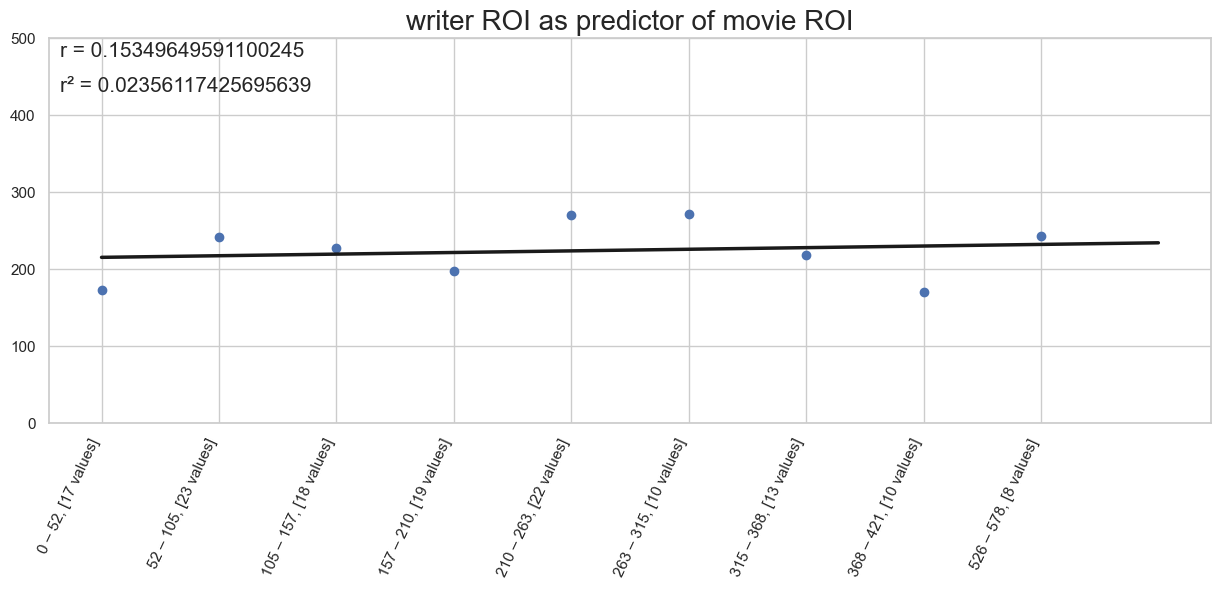

In [46]:
for profession in professions:
    plot(query(profession, 'ROI', 'ROI'))

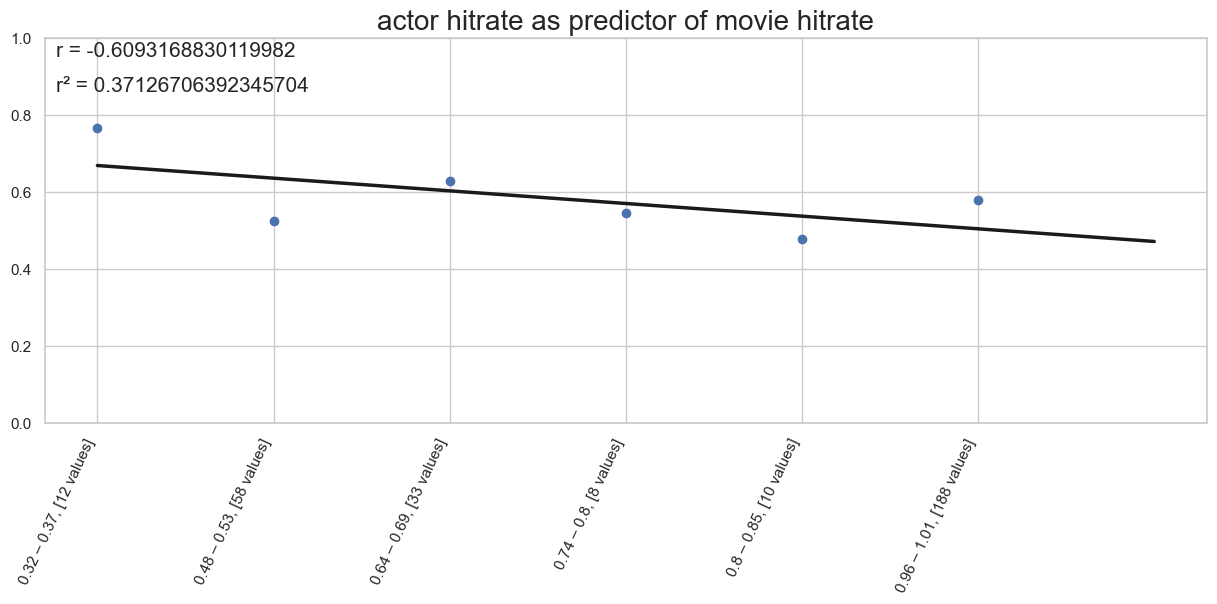

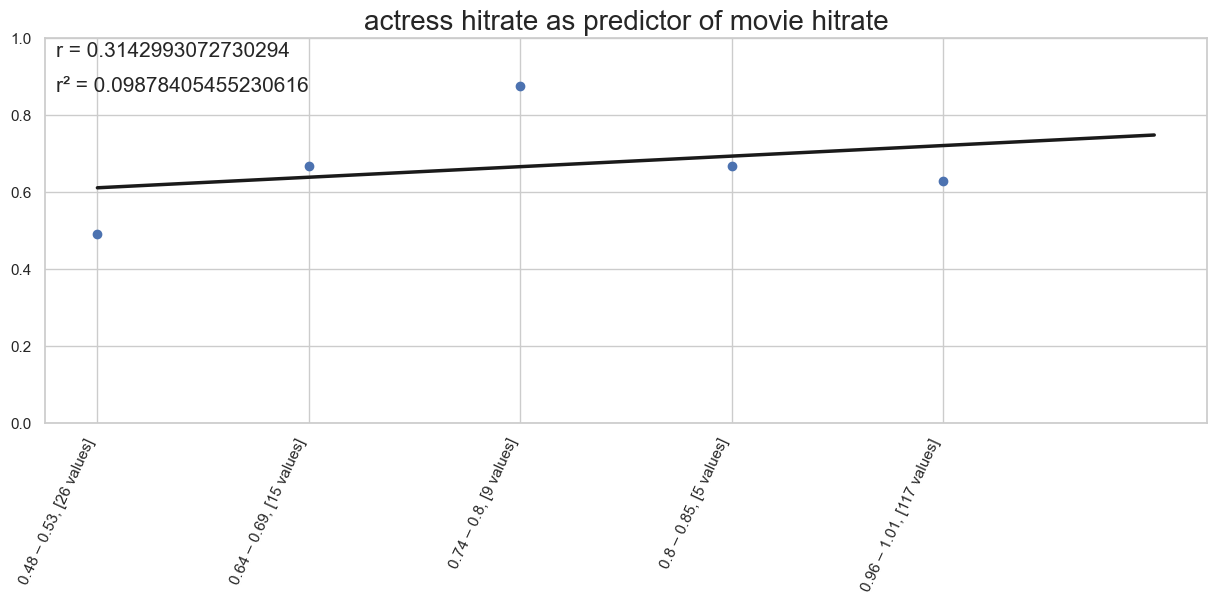

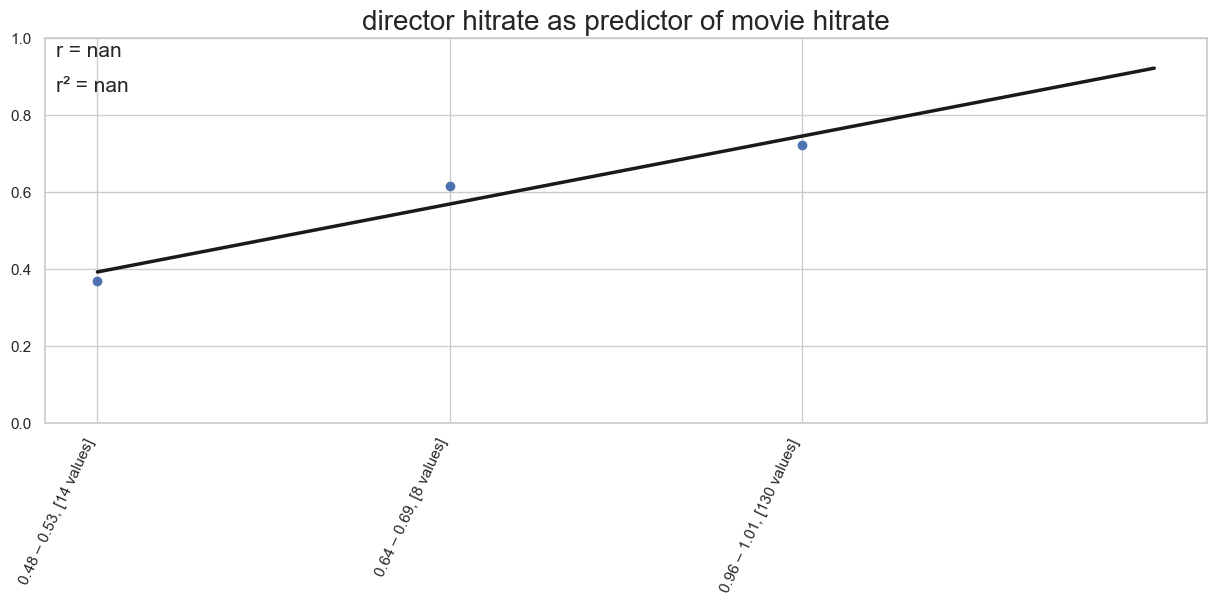

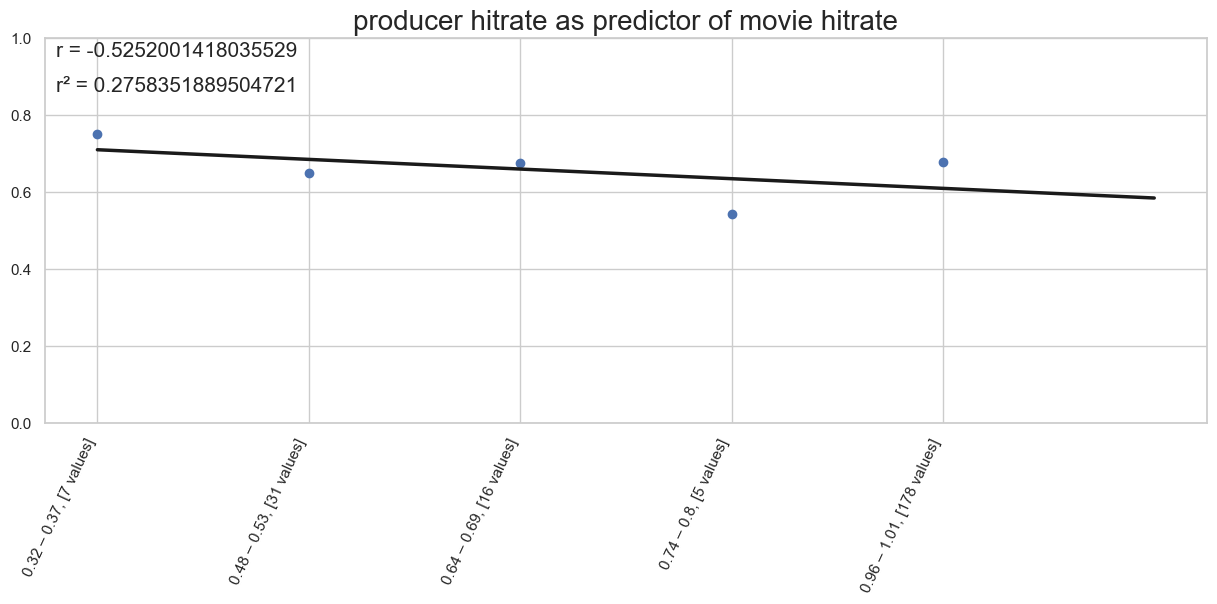

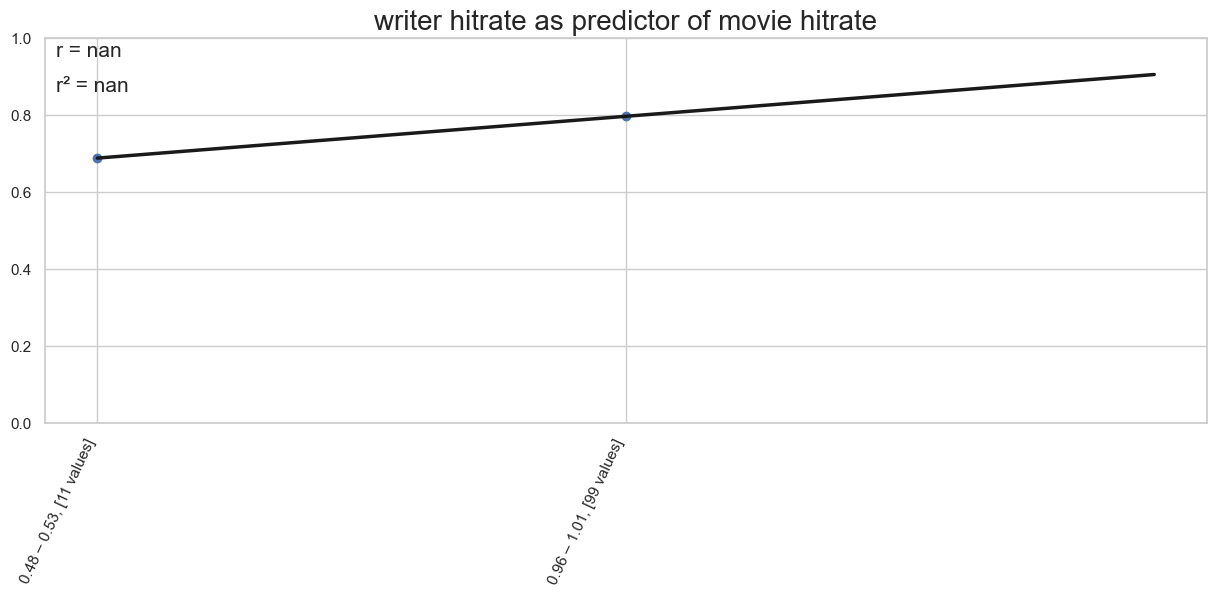

In [47]:
for profession in professions:
    plot(query(profession, 'hitrate', 'hitrate'))

# Cast – Level Up: Gathering more Data

This data is not informative enough. It's only from one year, and it only correlates profession ROI and movie ROI. Ideally, we would have information from multiple years, and we would also correlate:

- profession ROI and movie hitrate
- profession hitrate and movie hitrate
- profession hitrate and movie ROI

And then combine these correlations for an overall indicator on profession correlation with movie success.


### Which years?

Selecting years 2011-2015 is appropriate, since they all have >1000 unique people – and after we split the dataset, the average stat difference between people across datasets is under 10%, which is good for the accuracy of our results.

In [48]:
acceptable_years = range(2011,2016)

### Creating the shell of our dataframe

Our dataframe must have columns for each year and three indexes which indicate the values of the variables we're correlating:

- the type of profession
- the profession stat selected (ROI/profitable)
- the movie stat selected (ROI/profitable)

In [49]:
# Creating the first columns of our dataframe
attributes = ['ROI', 'hitrate']

profession = []
profession_attribute = []
movie_attribute = []


for p in professions:
    for a in attributes:
        for b in attributes:
            profession.append(p)
            profession_attribute.append(a)
            movie_attribute.append(b)

In [50]:
# The shell of our dataframe
data = {
    'profession': profession,
    'profession_attribute': profession_attribute,
    'movie_attribute': movie_attribute
}

pd.DataFrame(data)

,profession,profession_attribute,movie_attribute
0,actor,ROI,ROI
1,actor,ROI,hitrate
2,actor,hitrate,ROI
3,actor,hitrate,hitrate
4,actress,ROI,ROI
5,actress,ROI,hitrate
6,actress,hitrate,ROI
7,actress,hitrate,hitrate
8,director,ROI,ROI
9,director,ROI,hitrate


This looks good enough. Now we just need to populate more columns and append them to this dataframe.

In [51]:
# This loop gathers correlation data and appends it to new columns in the dataframe.
for year in acceptable_years:

    # Splitting our dataset down the year
    before = castdf[castdf.year <= year].copy()
    after = castdf[castdf.year > year].copy()
    
    # Getting the list of people in common
    intersection = set(before.person_id.unique()).intersection(set(after.person_id.unique()))
    len(intersection)

    # Reducing each dataset to only include people from the intersection
    before = before[before.person_id.isin(intersection)]
    after = after[after.person_id.isin(intersection)]
    
    # A column of correlations in a specific year – reset and appended to the dataframe every loop
    column = []
    
    # Creating the year column
    for p in professions:
        for a in attributes:
            for b in attributes:
                correlation = query(p, a, b)[5] # Retrieves correlation from query
                column.append(correlation) # Appends correlation to our column
    
    # Appends year column to the dataframe
    data[year] = column
    
    # A ticker to show you the progress of the loop (it takes a minute to complete)
    print("{} done.".format(year), end=" ")

2011 done. 2012 done. 2013 done. 2014 done. 2015 done. 

In [52]:
correlationsdf = pd.DataFrame(data)
correlationsdf

,profession,profession_attribute,movie_attribute,2011,2012,2013,2014,2015
0,actor,ROI,ROI,-0.156716,-0.412497,0.622866,0.724551,0.532006
1,actor,ROI,hitrate,-0.107841,-0.281808,0.601287,0.828959,0.526829
2,actor,hitrate,ROI,NaN,0.410339,-0.446581,0.257748,0.257552
3,actor,hitrate,hitrate,NaN,0.351818,-0.609317,0.259359,0.517121
4,actress,ROI,ROI,0.800327,0.159858,0.336188,0.209806,0.350807
5,actress,ROI,hitrate,0.628224,0.153364,0.290413,0.395016,0.529148
6,actress,hitrate,ROI,NaN,0.684529,0.190501,0.472533,0.588099
7,actress,hitrate,hitrate,NaN,0.702102,0.314299,0.590750,0.672349
8,director,ROI,ROI,0.363742,0.538020,0.629590,0.585066,0.442668
9,director,ROI,hitrate,0.318104,0.595163,0.720457,0.811061,0.568403


We have quite a few NaN values in this dataset, but it's better than including correlations that were otherwise meaningless or outright misleading, which could lead us to draw unwarranted conclusions.

### Aggregating data
Now let's aggregate all correlations accross profession and see what we have.

In [53]:
correlationsdf.groupby('profession').mean(numeric_only=True)

,2011,2012,2013,2014,2015
profession,,,,,
actor,-0.132279,0.016963,0.042064,0.517654,0.458377
actress,0.714275,0.424963,0.282850,0.417026,0.535101
director,0.340923,0.566591,0.675023,0.698064,0.505536
producer,0.394931,0.575656,0.245601,0.028422,0.320919
writer,0.257511,0.205890,0.406974,0.470371,0.233514


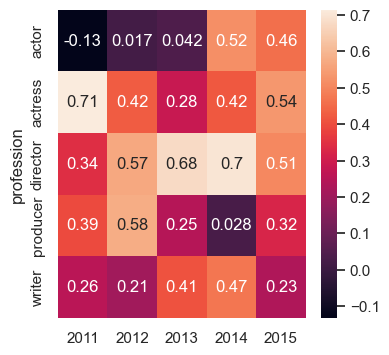

In [54]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(correlationsdf.groupby('profession').mean(numeric_only=True), ax=ax, annot=True);

### Averaging across year

There is only one negative correlation (there should be none), so that's good to see. Every profession's success here should correlate positively with movie success – the only question is, which professions correlate *more strongly* with movie success.

To know that, we need to aggregate one more time, this time across years, to get an overall indicator of a profession's success with movie success.

In [55]:
profession_correlations = \
            correlationsdf.groupby('profession').mean(numeric_only=True).mean(numeric_only=True, axis=1)

profession_correlations

profession
actor       0.180556
actress     0.474843
director    0.557227
producer    0.313106
writer      0.314852
dtype: float64

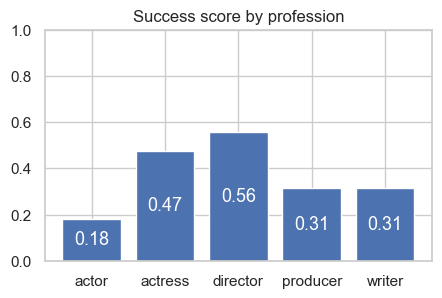

In [56]:
fig, ax = plt.subplots(figsize = (5,3))

x = profession_correlations.index
y = profession_correlations.values

barplot = ax.bar(x,y)
ax.set_ylim(0,1)

ax.bar_label(barplot, labels=[round(i,2) for i in y], label_type='center', color='white', fontsize='13');
ax.set_title('Success score by profession');

This is the data we've been after this entire section. The types of professions here can be broken down into two basic categories: on-screen and off-screen. Although there is some variability within these categories, its clear that the off-screen crew are more important to a movie's success than the on-screen crew – which makes sense, since the off-screen crew make decisions on who the on-screen crew will be.

In fact, we could aggregate this data *one more time* (!) by averaging the score for on-screen and off-screen crew.

### Averaging across profession

In [57]:
on_screen = (profession_correlations['actor'] +
             profession_correlations['actress'])/2

off_screen = (profession_correlations['director'] +
              profession_correlations['producer'] +
              profession_correlations['writer'])/3

print(f"The average correlation between on-screen crew success and movie success is {on_screen}.")
print(f"The average correlation between off-screen crew success and movie success is {off_screen}.")

The average correlation between on-screen crew success and movie success is 0.32769952582287626.
The average correlation between off-screen crew success and movie success is 0.3950617902418694.


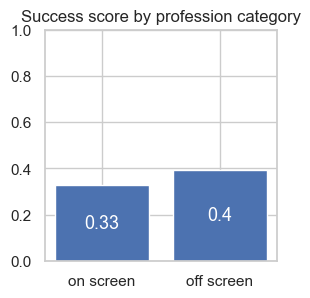

In [58]:
fig, ax = plt.subplots(figsize = (3,3))

x = ['on screen', 'off screen']
y = [on_screen, off_screen]

barplot = ax.bar(x,y)
ax.set_ylim(0,1)

ax.bar_label(barplot, labels=[round(i,2) for i in y], label_type='center', color='white', fontsize='13');
ax.set_title('Success score by profession category');

# Cast – Recommendation

The general recommendation for Microsoft when hiring cast & crew is to prioritize off-screen crew before the on-screen crew. More specifically, when allocating time and money to selecting and hiring off-screen crew, prioritize the directors before the producers and writers.

And... as much as I hate to say it (because I'm a guy), when allocating time and money to selecting and hiring on-screen crew... the actresses are more important than the actors.